In [2]:
# Standard Data Science Toolkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

# Machine Learning Preprocessing and Scoring Metrics
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RepeatedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
import psutil
import os

# Machine Learning Algorithms
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVC, SVR
from tpot import TPOTClassifier

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

c:\Users\Elija\anaconda3\envs\Cohort_Env\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [79]:
df = pd.read_csv('data.csv', index_col='date', parse_dates=["date"])
df.drop(columns=['open', 'high', 'low', 'adj_close'], inplace=True)     # Colinear features observed from EDA notebook
df.head()

,close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,
2000-01-03,94.75000,36345200,5.43,7.5,2.826171,4.1,111.3
2000-01-04,88.25000,33786600,5.38,7.5,2.826171,4.1,111.3
2000-01-05,86.00000,42496600,5.41,7.5,2.826171,4.1,111.3
2000-01-06,80.09375,37134800,5.54,7.5,2.826171,4.1,111.3
2000-01-07,90.00000,28138200,5.61,7.5,2.826171,4.1,111.3


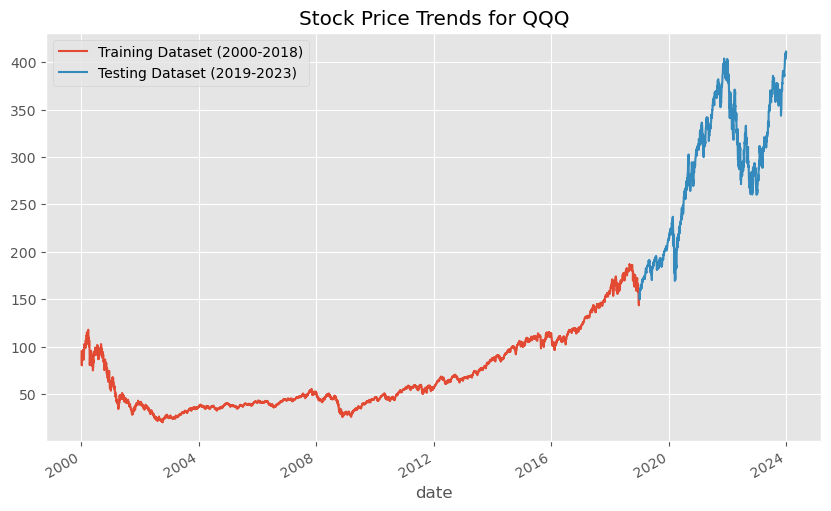

In [83]:
df['close'][:'2018-12-31'].plot(figsize=(10,6), legend=True)
df['close']['2019-01-01':].plot(figsize=(10,6), legend=True)

plt.legend(["Training Dataset (2000-2018)", "Testing Dataset (2019-2023)"])
plt.title("Stock Price Trends for QQQ")
plt.show()

In [84]:
train = df[df.index <= '2018-12-31']
test = df[df.index > '2018-12-31']

In [ ]:
X_train  = train.reset_index()
X_train.drop(columns=['date', 'close'], inplace=True)
display(X_train.head())

X_test  = test.reset_index()
X_test.drop(columns=['date', 'close'], inplace=True)
display(X_test.head())

,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
0,36345200,5.43,7.5,2.826171,4.1,111.3
1,33786600,5.38,7.5,2.826171,4.1,111.3
2,42496600,5.41,7.5,2.826171,4.1,111.3
3,37134800,5.54,7.5,2.826171,4.1,111.3
4,28138200,5.61,7.5,2.826171,4.1,111.3


,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
0,58576700,2.4,3.4,1.233584,3.8,93.8
1,74820200,2.4,3.4,1.233584,3.8,93.8
2,74709300,2.4,3.4,1.233584,3.8,93.8
3,52059300,2.4,3.4,1.233584,3.8,93.8
4,49388700,2.4,3.4,1.233584,3.8,93.8


In [86]:
y_train = train.reset_index()
y_train = y_train['close']
display(y_train.head())

y_test = test.reset_index()
y_test = y_test['close']
display(y_test.head())

0    94.75000
1    88.25000
2    86.00000
3    80.09375
4    90.00000
Name: close, dtype: float64

0    154.880005
1    149.820007
2    156.229996
3    158.089996
4    159.520004
Name: close, dtype: float64

In [90]:
mm_scaler = MinMaxScaler()

X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

In [94]:
def test_regression_models(X_train, y_train):
    # Adjustments
    CV = 10
    SCORING = 'neg_mean_squared_error' 
    
    # Define the models to be tested
    models = {
        "Linear Regression": LinearRegression(),
        "K-Nearest Neighbors": KNeighborsRegressor(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "Support Vector Regressor": SVR()
    }
    
    # Initialize results dictionary to store metrics for each model
    results = {
        "Model": [],
        "Mean Squared Error": [],
        "Spread (std)": [],
        "Train Time (s)": [],
        "Memory Usage (MB)": []
    }
    
    # Perform model evaluation for each model
    for model_name, model in models.items():
        # Measure training time
        start_train_time = time.time()

        # Perform k-fold cross-validation to evaluate the model on the training data
        cv_scores = cross_val_score(model, X_train, y_train, cv=CV, scoring=SCORING)

        end_train_time = time.time()
        train_time = end_train_time - start_train_time

        # Measure memory usage (in MB)
        memory_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
        
        # Convert MSE scores to positive values
        mse_scores = -cv_scores

        # Store the metrics in the results dictionary
        results["Model"].append(model_name)
        results["Mean Squared Error"].append(round(np.mean(mse_scores), 4))
        results["Spread (std)"].append(round(np.std(mse_scores), 4))
        results["Train Time (s)"].append(round(train_time, 4))
        results["Memory Usage (MB)"].append(round(memory_usage, 0))
        
    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results)
    
    # Print the results
    return results_df


In [95]:
test_regression_models(X_train_scaled, y_train)

,Model,Mean Squared Error,Spread (std),Train Time (s),Memory Usage (MB)
0,Linear Regression,1443.1902,1629.9934,0.0510,201.0
1,K-Nearest Neighbors,681.0830,968.1471,0.1558,202.0
2,Decision Tree,1809.2469,2229.9879,0.4331,202.0
3,Random Forest,1583.2468,2267.3146,32.4075,205.0
4,Gradient Boosting,1147.2363,2062.9006,8.2426,207.0
5,XGBoost,1443.2812,2204.5573,1.0834,215.0
6,Support Vector Regressor,761.3741,1391.4371,13.5159,214.0


Best performing model was the KNN. Let's see if we can boost performance.

___

___

### KNN

In [98]:
knn = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 7, 11],
    'weights': ['uniform', 'distance'],
    'leaf_size': [20, 30, 40],
    'p': [1,2],
    'metric': ['minkowski', 'manhattan', 'euclidean']
}

In [99]:
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=True)

In [100]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': [20, 30, 40],
                         'metric': ['minkowski', 'manhattan', 'euclidean'],
                         'n_neighbors': [3, 7, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=True)

In [101]:
best_knn = grid_search.best_estimator_
best_knn

KNeighborsRegressor(leaf_size=20, n_neighbors=3, p=1, weights='distance')

In [103]:
best_score = grid_search.best_score_
best_score

-4.590323358902087

In [104]:
best_knn_pred = best_knn.predict(X_test_scaled)

In [106]:
best_knn_r2 = r2_score(y_test, best_knn_pred)
best_knn_r2

-11.617642506142317

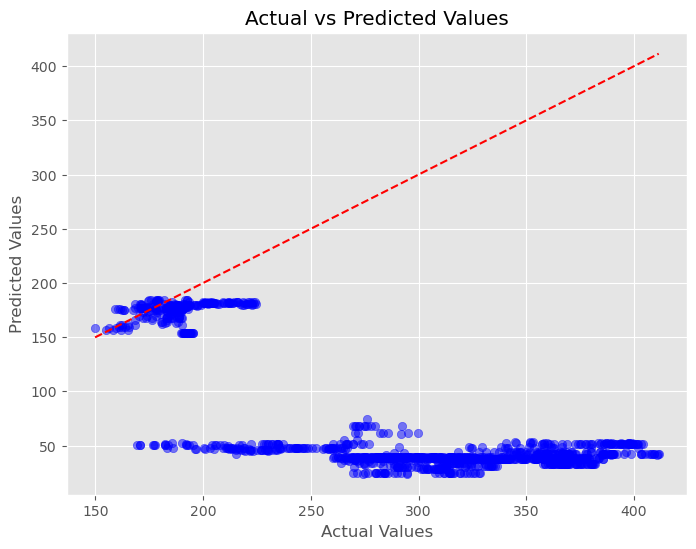

In [108]:
plt.figure(figsize=(8, 6))

# Scatter plot for actual vs predicted values
x = y_test
y = best_knn_pred
plt.scatter(x, y, color='blue', alpha=0.5)

# Add title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')


# Line showing perfect predictions
plt.plot([x.min(), x.max()], [x.min(), x.max()], color='red', linestyle='--')

plt.show()


Interpretation:

Even best KNN is unable to perform well on predictive task.

___

___

___

___

___

In [ ]:
X_train.head()

,open,high,low,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
0,96.1875,96.1875,90.7500,36345200,5.43,7.5,2.826171,4.1,111.3
1,92.0000,93.5000,87.9375,33786600,5.38,7.5,2.826171,4.1,111.3
2,87.5000,89.6250,84.2500,42496600,5.41,7.5,2.826171,4.1,111.3
3,86.8750,88.0000,79.7500,37134800,5.54,7.5,2.826171,4.1,111.3
4,82.9375,90.0000,82.5000,28138200,5.61,7.5,2.826171,4.1,111.3


In [ ]:
mm_scaler = MinMaxScaler(feature_range=(0,1))

train_scaled = mm_scaler.fit_transform(train)

In [ ]:
np.shape(train)

(4779, 10)

In [ ]:
X_train, y_train = list(), list()
train_size = len(train_scaled)
timesteps = 30

for iteration in range(timesteps, train_size):
    X_train.append(train_scaled[iteration - timesteps: iteration, :])
    y_train.append(train_scaled[iteration, 3])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_train.shape

(4749, 30, 10)

In [ ]:
# Scale all features (open, high, low, close, volume, etc.) for both train and test data
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the scaler on the training data (train includes all features)
train_scaled = scaler.fit_transform(train)

# Transform the test data using the already fitted scaler
test_scaled = scaler.transform(test)

# Prepare the data for LSTM model (create sequences for both train and test)
X_train, y_train = list(), list()
X_test = list()

# Prepare sequences for the training set
for i in range(timesteps, len(train_scaled)):
    X_train.append(train_scaled[i - timesteps:i, :])  # Use all features
    y_train.append(train_scaled[i, 3])  # Target is the 'close' price, which is at index 3

# Prepare sequences for the testing set
for i in range(timesteps, len(test_scaled)):
    X_test.append(test_scaled[i - timesteps:i, :])  # Use all features

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Reshape the data for LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Now your model can be trained on X_train and evaluated on X_test


In [ ]:
INPUT_RECURRENT_LAYER =   LSTM(50,
                               return_sequences=True,
                               input_shape=(30, 10))
SECOND_RECURRENT_LAYER =  LSTM(50,
                               return_sequences=True)
THIRD_RECURRENT_LAYER =   LSTM(50,
                               return_sequences=True)
FOURTH_RECURRENT_LAYER =  LSTM(50)

# Four dropout regularization layers
FIRST_DROPOUT_LAYER =     Dropout(0.2)
SECOND_DROPOUT_LAYER =    Dropout(0.2)
THIRD_DROPOUT_LAYER =     Dropout(0.2)
FOURTH_DROPOUT_LAYER =    Dropout(0.2)

# One dense connective layer for prediction output
OUTPUT_CONNECTIVE_LAYER = Dense(1)

In [ ]:
model = Sequential()

model.add(INPUT_RECURRENT_LAYER)
model.add(FIRST_DROPOUT_LAYER)
model.add(SECOND_RECURRENT_LAYER)
model.add(SECOND_DROPOUT_LAYER)
model.add(THIRD_RECURRENT_LAYER)
model.add(THIRD_DROPOUT_LAYER)
model.add(FOURTH_RECURRENT_LAYER)
model.add(FOURTH_DROPOUT_LAYER)
model.add(OUTPUT_CONNECTIVE_LAYER)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 50)            12200     
                                                                 
 dropout_8 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [ ]:
model.compile(optimizer="rmsprop",
              loss="mean_squared_error")

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10, batch_size=32,
                    verbose=True)

Epoch 1/10
149/149 [==============================] - 33s 114ms/step - loss: 0.0076
Epoch 2/10
149/149 [==============================] - 19s 126ms/step - loss: 0.0036
Epoch 3/10
149/149 [==============================] - 20s 135ms/step - loss: 0.0028
Epoch 4/10
149/149 [==============================] - 16s 107ms/step - loss: 0.0024
Epoch 5/10
149/149 [==============================] - 16s 108ms/step - loss: 0.0022
Epoch 6/10
149/149 [==============================] - 16s 107ms/step - loss: 0.0018
Epoch 7/10
149/149 [==============================] - 15s 102ms/step - loss: 0.0017
Epoch 8/10
149/149 [==============================] - 15s 103ms/step - loss: 0.0015
Epoch 9/10
149/149 [==============================] - 16s 104ms/step - loss: 0.0015
Epoch 10/10
149/149 [==============================] - 16s 105ms/step - loss: 0.0014


In [ ]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Concatenate zeros for the non-target features (9 features), so the shape matches the original data (10 columns in total)
# Ensure predictions are reshaped to be in the correct shape for concatenation
predictions_reshaped = np.concatenate((np.zeros((predictions.shape[0], 9)), predictions), axis=1)

# Use inverse_transform with the reshaped predictions
predictions_rescaled = mm_scaler.inverse_transform(predictions_reshaped)[:, -1]


39/39 [==============================] - 1s 30ms/step


In [ ]:
# Ensure y_test is a NumPy array and reshape it to be 2D
y_test = y_test.values.reshape(-1, 1)  # Convert Series to NumPy array and reshape

# Concatenate zeros for the non-target features (9 features)
y_test_reshaped = np.concatenate((np.zeros((y_test.shape[0], 9)), y_test), axis=1)

# Use inverse_transform with the reshaped y_test values
y_test_rescaled = mm_scaler.inverse_transform(y_test_reshaped)[:, -1]


In [ ]:
# Make predictions
predictions = model.predict(X_test)


39/39 [==============================] - 1s 30ms/step


In [ ]:
# Reshape predictions to match the scaler's expected input shape
predictions_reshaped = np.concatenate((np.zeros((predictions.shape[0], 9)), predictions), axis=1)

# Inverse transform the predictions
predictions_rescaled = mm_scaler.inverse_transform(predictions_reshaped)[:, -1]


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared
r2 = r2_score(y_test_rescaled, predictions_rescaled)
print(f'R-squared: {r2}')


ValueError: Found input variables with inconsistent numbers of samples: [1812, 1228]

In [ ]:
# Get target data for both train and test periods
target = pd.concat((df['close']['2000-01-01':'2018-12-31'], df['close']['2019-01-01':]), axis=0)

# Prepare testing data from the target
testing_values = target[len(target) - len(test) - timesteps:].values
testing_values = testing_values.reshape(-1, 1)  # Reshape the values for scaling
testing_values = mm_scaler.transform(testing_values)  # Apply the same scaling as training data

# Prepare the sequences for test data (X_test)
X_test = list()
for i in range(timesteps, len(testing_values)):
    X_test.append(testing_values[i - timesteps:i, 0])  # Use the last 'timesteps' data points

X_test = np.array(X_test)  # Convert to numpy array

# Reshape the data for LSTM (samples, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions using the trained model
predictions = model.predict(X_test)

# Inverse transform the predicted values back to the original scale
predictions = mm_scaler.inverse_transform(predictions)


ValueError: X has 1 features, but MinMaxScaler is expecting 10 features as input.

In [ ]:
train = df['2000-01-01':'2018-12-31'].values
test = df['2019-01-01':].values